In [55]:
!pip install timm
!pip install rasterio

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import os
!pwd
os.chdir(os.path.join("drive","MyDrive","Colab Notebooks","swirsyntesiser"))


/content/drive/My Drive/Colab Notebooks/swirsyntesiser


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/swirsyntesiser'

In [ ]:
os.mkdir("/content/dataset")

In [ ]:
import shutil
def copy_tif_images(folder_a, folder_b):
    # Create the destination folder if it doesn't exist
    os.makedirs(folder_b, exist_ok=True)

    # Initialize a counter
    counter = 0

    # Iterate through all files in the source folder
    for filename in os.listdir(folder_a):
        # Check if the file is a .tif image
        if filename.lower().endswith('.tif'):
            # Construct full file paths
            source_path = os.path.join(folder_a, filename)
            destination_path = os.path.join(folder_b, filename)

            # Copy the file
            shutil.copy2(source_path, destination_path)
            counter += 1
            print(f"Copied: {source_path} to {destination_path}")

    # Print the total number of files copied
    print(f"Total .tif files copied: {counter}")

In [ ]:
!ls

In [ ]:
import gdown
file_id = "1MHeSPa2t7XNltA9QJzbTz8cSBFgiu4KB"
zip_url = f'https://drive.google.com/uc?id={file_id}'
zip_target = "/content/compressed_data.zip"

gdown.download(zip_url,zip_target, quiet=False)

In [ ]:
import zipfile

# Specify the directory where you want to extract the zip file
extract_dir = '/content/new_dataset'  # Replace with your desired directory

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_target, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted files to {extract_dir}")

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from src.vit_model.mae import MaskedAutoencoderViT

In [ ]:
model = MaskedAutoencoderViT(
    img_size=224,
    patch_size=16,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_depth=2,
    mlp_ratio=4,
    decoder_num_heads=6,
    decoder_embed_dim=192,
)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

In [ ]:
# load pretrained weights
# print(model.state_dict().keys())
new_state_dict = torch.load('mae_pretrain_vit_base.pth')['model']

# copy and freeze the parameters:
for name, param in model.named_parameters():
    if name in new_state_dict:
        param.requires_grad = False
        param.copy_(new_state_dict[name])
    else:
        print(f'not copied: {name}')



In [ ]:
#import vgg 16
import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self, feature_layers = (3, 8, 15, 22, 29)):
        super().__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights).features
        self.vgg = self.vgg.cuda()

        self.vgg_slices = [self.vgg[:layer].eval() for layer in feature_layers]
        # print layers
        # for i, layer in enumerate(self.vgg_slices):
        #     print(f'Layer {i}: {layer}')

        # for i, layer in enumerate(self.vgg):
        #     print(f'Layer {i}: {layer}')
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, y_pred,y_true):
        if y_pred.size(1) == 1:
            y_pred = y_pred.repeat(1, 3, 1, 1)
        if y_true.size(1) == 1:
            y_true = y_true.repeat(1, 3, 1, 1)
        loss = 0
        x = y_pred
        y = y_true
        for i, vgg_slice in enumerate(self.vgg_slices):
            x = vgg_slice(y_pred)
            y = vgg_slice(y_true)

            loss += F.mse_loss(x, y)
        return loss



In [ ]:
class LossTracker:
    def __init__(self):
        self.reset()

    def update(self, mse_loss, perceptual_loss):
        self.mse_sum += mse_loss.item()
        self.perceptual_sum += perceptual_loss.item()
        self.count += 1

    def mean(self):
        mse_mean = self.mse_sum / self.count
        perceptual_mean = self.perceptual_sum / self.count
        return mse_mean, perceptual_mean

    def reset(self):
        self.mse_sum = 0.0
        self.perceptual_sum = 0.0
        self.count = 0
def calculate_ndmi(nir, swir):
    ndmi = (nir - swir) / (nir + swir)
    return ndmi

def plot_ndmi(ndmi_map,title='NDMI Index Map', vmin=-1.0, vmax=1.0):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(ndmi_map.cpu().numpy(), vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel(f'Min: {vmin}, Max: {vmax}')
    plt.colorbar(im, ax=ax)
    plt.show()


In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.mse_loss = nn.MSELoss()
        self.perceptual_loss = PerceptualLoss()
        self.reset()

    def reset(self):
        self.mse_sum = 0.0
        self.perceptual_sum = 0.0
        self.count = 0

    def update(self):
        if self.count != 0:
            self.mse_mean = self.mse_sum / self.count
            self.perceptual_mean = self.perceptual_sum / self.count
        else:
            self.mse_mean = 1.0
            self.perceptual_mean = 1.0

    def forward(self, output, target):
        # Compute individual losses
        loss_mse = self.mse_loss(output, target)
        loss_perceptual = self.perceptual_loss(output, target)

        # Track the losses
        self.mse_sum += loss_mse.item()
        self.perceptual_sum += loss_perceptual.item()
        self.count += 1

        # Normalize the losses by the mean values
        normalized_mse = loss_mse / self.mse_mean
        normalized_perceptual = loss_perceptual / self.perceptual_mean

        # Combine the normalized losses with given weights
        total_loss = self.alpha * normalized_mse + self.beta * normalized_perceptual
        return total_loss

class CombinedNDMILoss(nn.Module):
    def __init__(self, nir_band_idx, swir_band_idx):
        super(CombinedNDMILoss, self).__init__()
        self.nir_band_idx = nir_band_idx
        self.swir_band_idx = swir_band_idx
        self.mse_loss = nn.MSELoss()

    def calculate_ndmi(self, nir, swir):
        ndmi = (nir - swir) / (nir + swir)
        return ndmi

    def forward(self, y_pred, y, img):
        # Compute MSE for y and y_pred
        mse_loss = self.mse_loss(y_pred, y)

        # Extract NIR and SWIR bands
        nir = img[:, self.nir_band_idx, :, :]
        swir = img[:, self.swir_band_idx, :, :]
        synth_swir = y_pred[:, 0, :, :]

        # Calculate NDMI for original and synthetic SWIR
        ndmi_map_original = self.calculate_ndmi(nir, swir)
        ndmi_map_synth = self.calculate_ndmi(nir, synth_swir)

        # Compute MSE for NDMI maps
        ndmi_loss = self.mse_loss(ndmi_map_synth, ndmi_map_original)
        if torch.isnan(ndmi_loss) or torch.isinf(ndmi_loss):
            # print("NaN value detected in NDMI loss!")
            # Handle NaN case here (e.g., set loss to zero or another value)
            ndmi_loss = torch.tensor(100000.0, device=ndmi_loss.device)
        # Combine losses
        combined_loss = mse_loss + ndmi_loss
        print(mse_loss)
        print(ndmi_loss)
        return combined_loss

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
model = model.cuda()

In [ ]:
from torch.utils.data import DataLoader,Dataset
import os

class EuroSATDataset(Dataset):
    def __init__(self, files, path):
        self.file_list = files
        self.path = path
        self.bands = 13


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        with rasterio.open(os.path.join(self.path, self.file_list[idx])) as src:
            img = src.read()
            img = torch.tensor(img).float()
            img = img / 255.0
            img = img * 2.0 - 1.0
            img = img.unsqueeze(0)
            img = F.interpolate(img, size=(224, 224), mode = "bilinear")
            img = img.squeeze(0)
            x = img[2:4+1]
            y = img[11].unsqueeze(0)
            return x, y, img


class EuroSATDatasetAutoEncoder(Dataset):
    def __init__(self, files, path):
        self.file_list = files
        self.path = path
        self.bands = 13


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        with rasterio.open(os.path.join(self.path, self.file_list[idx])) as src:
            img = src.read()
            img = torch.tensor(img).float()
            img = img / 255.0
            img = img * 2.0 - 1.0
            img = img.unsqueeze(0)
            img = F.interpolate(img, size=(224, 224), mode = "bilinear")
            img = img.squeeze(0)
            x = img[3:5+1]
            y = x
            return x, y, img



In [ ]:
import torch.optim as optim
batch_size = 32

files = os.listdir('/content/new_dataset/full')

train = files[:int(len(files)*0.8)]
test = files[int(len(files)*0.8):]
print(train)
train_dataset = EuroSATDataset(train,'/content/new_dataset/full')
test_dataset = EuroSATDataset(test,'/content/new_dataset/full')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers = 2,drop_last=True)


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers = 2,drop_last=True)

In [ ]:

print(len(train_dataset))
print(len(train_loader))

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# loss_fn =CombinedLoss(beta = 3.0).cuda()
loss_fn =nn.MSELoss()
epochs = 4

In [ ]:
model.train()
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    # loss_fn.update()
    # loss_fn.reset()
    for j,batch in enumerate(train_loader):
        x,y,_ = batch
        x = x.cuda()
        y = y.cuda()


        optimizer.zero_grad()
        y_pred,mask, _= model(x,mask_ratio=0.0)
        # print(mask, len(mask))
        # print(y_pred.shape)

        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        if j%50 == 0:
            print(f"Epoch {i+1}\t Loss: {loss.item()}\tStep: {j}/{len(train_loader)}")
    # print(f"Loss: {loss.item()}\tStep: {len(train_loader)}/{len(train_loader)}")


    # print("epoch end")

Epoch 1/4
Epoch 1	 Loss: 128.56396484375	Step: 0/675
Epoch 1	 Loss: 15.459053993225098	Step: 50/675
Epoch 1	 Loss: 6.490694522857666	Step: 100/675
Epoch 1	 Loss: 4.919679164886475	Step: 150/675
Epoch 1	 Loss: 7.512426853179932	Step: 200/675
Epoch 1	 Loss: 5.1582465171813965	Step: 250/675
Epoch 1	 Loss: 2.5114824771881104	Step: 300/675
Epoch 1	 Loss: 4.3182053565979	Step: 350/675
Epoch 1	 Loss: 6.22663688659668	Step: 400/675
Epoch 1	 Loss: 5.554201126098633	Step: 450/675
Epoch 1	 Loss: 3.861504316329956	Step: 500/675
Epoch 1	 Loss: 7.652400970458984	Step: 550/675
Epoch 1	 Loss: 4.083881855010986	Step: 600/675
Epoch 1	 Loss: 5.133745193481445	Step: 650/675
Epoch 2/4
Epoch 2	 Loss: 7.438624858856201	Step: 0/675
Epoch 2	 Loss: 4.723325729370117	Step: 50/675
Epoch 2	 Loss: 6.406972408294678	Step: 100/675
Epoch 2	 Loss: 5.1673150062561035	Step: 150/675
Epoch 2	 Loss: 3.0837080478668213	Step: 200/675
Epoch 2	 Loss: 5.124176502227783	Step: 250/675
Epoch 2	 Loss: 6.327654838562012	Step: 300/675

torch.Size([32, 1, 224, 224])
tensor(3.9824, device='cuda:0')


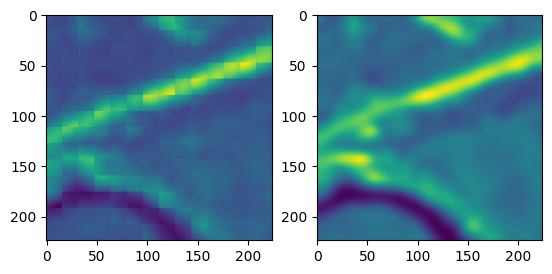

In [58]:

with torch.no_grad():
    x,y,img= next(iter(test_loader))
    x = x.cuda()
    y = y.cuda()
    img = img.cuda()
    y_pred,_,_ = model(x)
    print(y_pred.shape)
    print(loss_fn(y_pred,y))
    # plot it next to each other
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(y_pred[0,0].cpu().numpy())
    axs[1].imshow(y[0,0].cpu().numpy())
    plt.show()


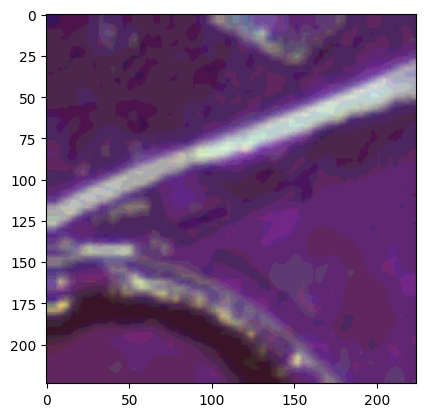

In [59]:
new_img = np.moveaxis(img[0,2:5,:,:].cpu().int().numpy(),0,-1)

diff = 255//new_img.max()

plt.imshow(new_img * diff)
plt.show()

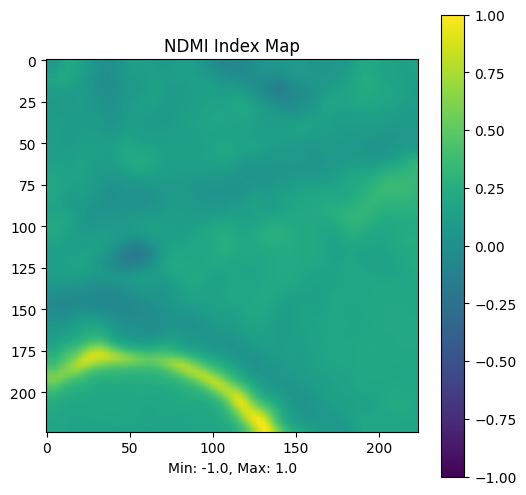

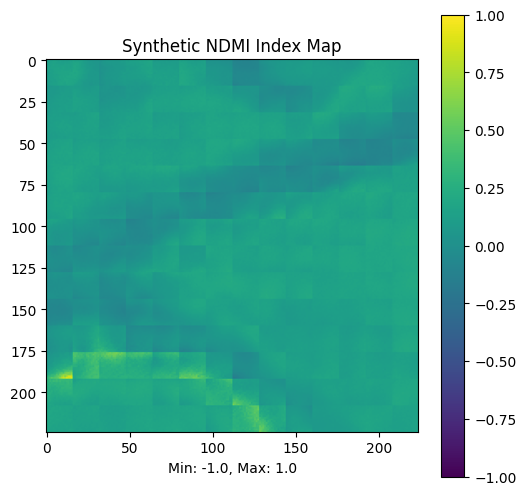

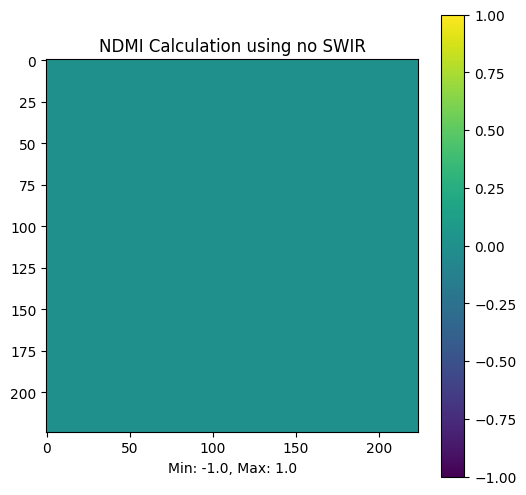

In [62]:
def calculate_ndmi(nir, swir):
    ndmi = (nir - swir) / (nir + swir)
    return ndmi

# def plot_ndmi(ndmi_map, vmin=-1.0, vmax=1.0):
#     fig, ax = plt.subplots(figsize=(6, 6))
#     im = ax.imshow(ndmi_map.cpu().numpy(), vmin=vmin, vmax=vmax, cmap='viridis')
#     ax.set_title('NDMI Index Map')
#     ax.set_xlabel(f'Min: {vmin}, Max: {vmax}')
#     plt.colorbar(im, ax=ax)
#     plt.show()

def create_and_plot_ndmi(image_path, nir_band_idx, swir_band_idx, model):
    with torch.no_grad():


        # Extract NIR and SWIR bands
        nir = img[0][nir_band_idx]
        swir = img[0][swir_band_idx]
        synth_swir = y_pred[0][0]

        # Calculate NDMI
        ndmi_map_original = calculate_ndmi(nir, swir)

        ndmi_map_synth = calculate_ndmi(nir, synth_swir)

        nothing = torch.tensor(np.zeros(nir.shape)).cuda()

        ndmi_map_no_swir = calculate_ndmi(nir, nir)


        # Plot NDMI map
        plot_ndmi(ndmi_map_original)

        plot_ndmi(ndmi_map_synth, title = "Synthetic NDMI Index Map")

        plot_ndmi(ndmi_map_no_swir, title = "NDMI Calculation using no SWIR")



nir_band_idx = 4  # Change this index based on your data
swir_band_idx = 11  # Change this index based on your data
create_and_plot_ndmi('/content/new_dataset/full/AnnualCrop_1.tif', nir_band_idx, swir_band_idx, model)

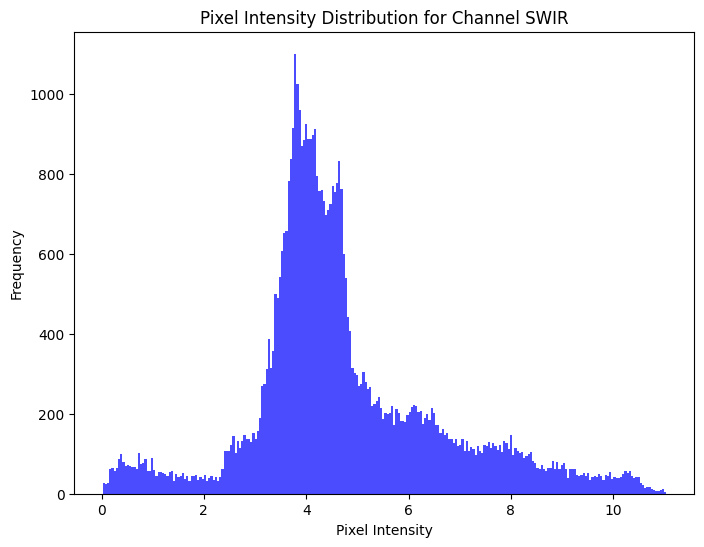

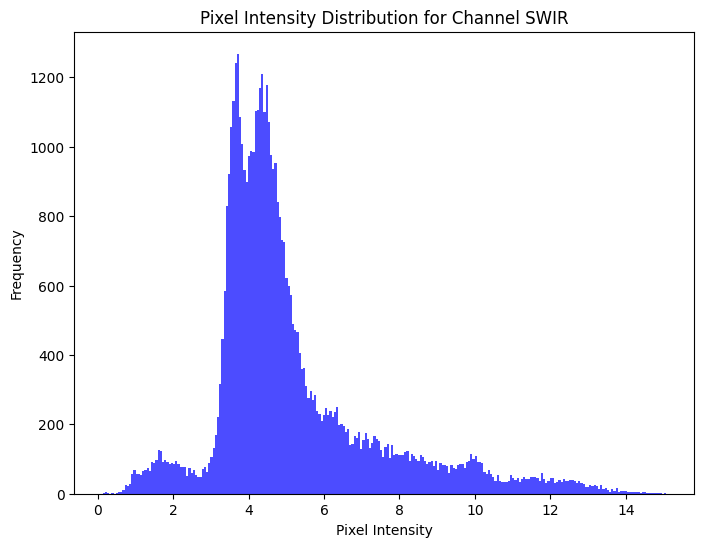

In [64]:

def plot_channel_distribution(image, bins=256):
    """
    Plots the color distribution of a specific channel in the image.

    Parameters:
    - image (numpy array): The image to analyze. Can have any range of values.
    - channel_index (int): The index of the channel to plot. Default is 0.
    - bins (int): Number of bins to use in the histogram. Default is 256.
    """
    # Extract the channel from the image
    channel = image

    # Flatten the channel to get all pixel values in a single array
    channel_values = channel.flatten()

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(channel_values, bins=bins, color='blue', alpha=0.7)

    # Set plot labels and title
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(f'Pixel Intensity Distribution for Channel SWIR')

    # Show the plot
    plt.show()
swir = img[0][swir_band_idx].cpu().numpy()
synth_swir = y_pred[0][0].cpu().numpy()
plot_channel_distribution(swir)

plot_channel_distribution(synth_swir)

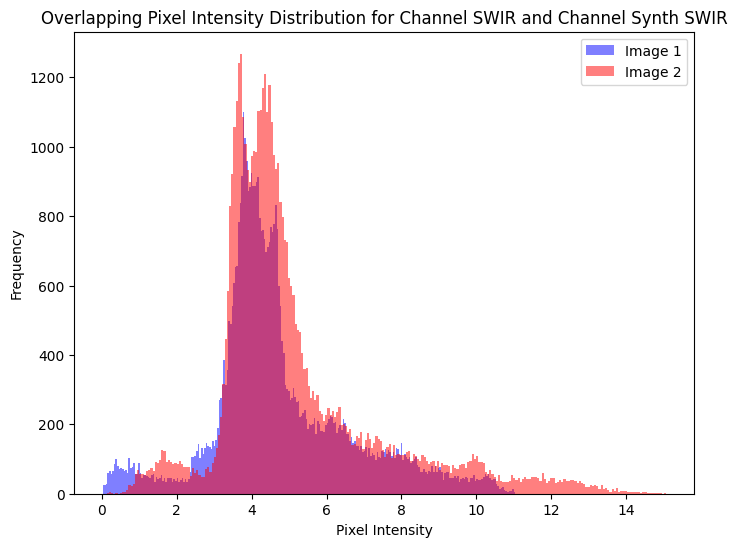

In [65]:
def plot_overlapping_channel_distribution(image1, image2, bins=256, label1='Image 1', label2='Image 2'):
    """
    Plots the color distribution of two specific channels from two images and overlaps the histograms.

    Parameters:
    - image1, image2 (numpy arrays): The images to analyze.
    - channel_index1, channel_index2 (int): The index of the channels to plot from each image.
    - bins (int): Number of bins to use in the histogram. Default is 256.
    - label1, label2 (str): Labels for the histograms of the two images.
    """
    # Extract the channels from the images
    channel1 = image1[...].flatten()
    channel2 = image2[...].flatten()

    # Plot the histograms with overlapping colors
    plt.figure(figsize=(8, 6))
    plt.hist(channel1, bins=bins, color='blue', alpha=0.5, label=label1)
    plt.hist(channel2, bins=bins, color='red', alpha=0.5, label=label2)

    # Set plot labels and title
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(f'Overlapping Pixel Intensity Distribution for Channel SWIR and Channel Synth SWIR')

    # Add a legend to differentiate the two histograms
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

plot_overlapping_channel_distribution(swir,synth_swir)

In [ ]:
import datetime

# Get the current date and time
model_save_path = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

model_save_path = "latest.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to 20240918_010239
Model saved to latest.pth


In [23]:
model.load_state_dict(torch.load('latest.pth'))
model = model.cuda()

<ipython-input-23-df5414426b32>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('latest.pth'))


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

# Assuming model, test_loader, and loss_fn (e.g., nn.MSELoss()) are defined
model.eval()

# Initialize lists for storing metrics per batch
all_losses = []
all_mses = []

device = "cuda"

# Helper function to compute mean and standard deviation
def plot_with_avg_and_std(batches, values, ylabel, title, ylim=None):
    values = np.array(values)
    avg = np.mean(values)
    std = np.std(values)

    plt.plot(batches, values, label='Value')
    plt.axhline(y=avg, color='r', linestyle='--', label='Average')
    plt.axhline(y=avg + std, color='g', linestyle='--', label='Average + 1 Std')
    plt.axhline(y=avg - std, color='g', linestyle='--', label='Average - 1 Std')

    plt.xlabel('Batch')
    plt.ylabel(ylabel)
    plt.title(title)

    if ylim:
        plt.ylim(ylim)

    plt.legend()

# Test loop with no gradients
with torch.no_grad():
    for inputs, targets, _ in tqdm(test_loader):
        # Move to GPU if available
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        y_pred, _, _ = model(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, targets)

        # Calculate MSE manually
        y_pred = torch.mean(y_pred, axis=1, keepdim=True)
        mse = nn.functional.mse_loss(y_pred, targets, reduction='none').mean(dim=[1, 2, 3])

        # Store loss and mse per batch
        all_losses.append(loss.cpu().item())
        all_mses.append(mse.cpu().numpy().mean())

# After the loop, plot Loss and MSE


100%|██████████| 168/168 [01:20<00:00,  2.09it/s]


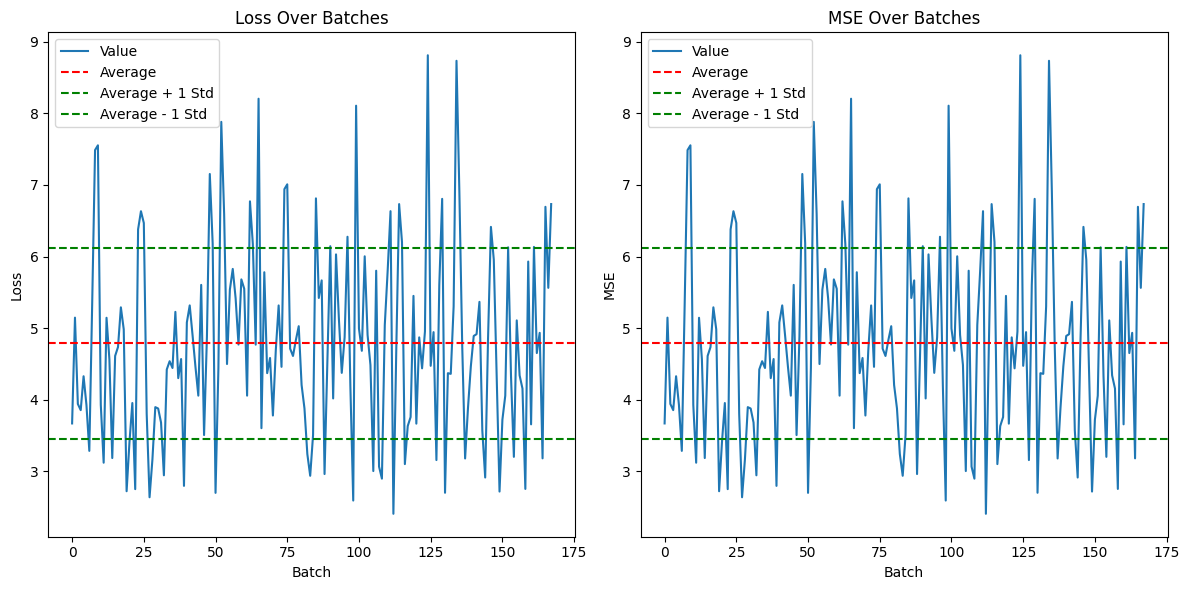

In [27]:

batches = range(len(all_losses))  # Each batch has its own index

plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plot_with_avg_and_std(batches, all_losses, 'Loss', 'Loss Over Batches')

# Plot MSE
plt.subplot(1, 2, 2)
plot_with_avg_and_std(batches, all_mses, 'MSE', 'MSE Over Batches')

plt.tight_layout()
plt.show()
